In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
# =======================
# 1. LOAD DATA
# =======================
df = pd.read_csv("synthetic_data.csv")

print("Dataset shape:", df.shape)
print(df.head())


Dataset shape: (10000, 19)
   avgAccuracy  stdAccuracy   Avgscore  AvgDuration  std_duration    meanRt  \
0     0.687270     0.143410  86.499916    41.907228      7.380417  1.770855   
1     0.975357     0.133228  59.225600    32.964623      3.706720  1.241776   
2     0.865997     0.094038  67.331985    58.224926      4.274466  0.793198   
3     0.799329     0.201817  83.164032    20.948923      5.252080  1.604963   
4     0.578009     0.169156  74.104467    39.392821      5.665760  1.128017   

      stdRt  AvgDifficulty  MaxSequence  decision_confidence  cognitive_load  \
0  0.396622       1.383950    17.272467             0.371830        0.500503   
1  0.452441       8.456542     7.179046             0.651715        0.611492   
2  0.285272       3.243768    19.196957             0.512788        0.491289   
3  0.215671       3.555436    17.648362             0.512830        0.546014   
4  0.227539       3.036208    18.782799             0.347846        0.474212   

   fatigue_index 

In [3]:
df.columns

Index(['avgAccuracy', 'stdAccuracy', 'Avgscore', 'AvgDuration', 'std_duration',
       'meanRt', 'stdRt', 'AvgDifficulty', 'MaxSequence',
       'decision_confidence', 'cognitive_load', 'fatigue_index',
       'behavior_drift', 'speed', 'memory', 'focus', 'flexibility',
       'attention', 'drift'],
      dtype='object')

In [4]:

# Features and targets
input_features = [
    'avgAccuracy', 'stdAccuracy', 'Avgscore', 'AvgDuration',
    'std_duration', 'meanRt', 'stdRt', 'AvgDifficulty', 'MaxSequence'
]
intermediate_targets = [
    'decision_confidence', 'cognitive_load',
    'fatigue_index', 'behavior_drift'
]
final_targets = [
    'speed', 'memory', 'focus',
    'flexibility', 'attention', 'drift'
]

X = df[input_features].values
y1 = df[intermediate_targets].values
y2 = df[final_targets].values

In [5]:
scaler_X = MinMaxScaler()
scaler_y1 = MinMaxScaler()
scaler_y2 = MinMaxScaler()

In [6]:
# Fit scalers on full data (acceptable for synthetic data; in real data, fit on train only)
X_scaled = scaler_X.fit_transform(X)
y1_scaled = scaler_y1.fit_transform(y1)
y2_scaled = scaler_y2.fit_transform(y2)

# Convert to tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y1_tensor = torch.tensor(y1_scaled, dtype=torch.float32)
y2_tensor = torch.tensor(y2_scaled, dtype=torch.float32)

In [7]:
# Split train/test
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(
    X_tensor, y1_tensor, y2_tensor, test_size=0.2, random_state=42
)


In [8]:

# DataLoaders
train_ds = TensorDataset(X_train, y1_train, y2_train)
test_ds = TensorDataset(X_test, y1_test, y2_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

In [9]:
# ===========================
# 2. Define models
# ===========================

# Stage 1: Input → Intermediates
class Stage1NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(9, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 4),
            nn.Sigmoid()  # outputs in [0,1]
        )
    def forward(self, x):
        return self.net(x)

In [10]:
# Stage 2: Intermediates → Final
class Stage2NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 6),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

stage1_model = Stage1NN()
stage2_model = Stage2NN()

In [11]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer1 = optim.Adam(stage1_model.parameters(), lr=0.001)
optimizer2 = optim.Adam(stage2_model.parameters(), lr=0.001)

In [12]:
# ===========================
# 3. Training loop
# ===========================
n_epochs = 300
patience = 20
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(n_epochs):
    stage1_model.train()
    stage2_model.train()
    train_loss1 = 0.0
    train_loss2 = 0.0

    for xb, y1_true, y2_true in train_loader:
        # --------- Stage 1 ---------
        optimizer1.zero_grad()
        y1_pred = stage1_model(xb)
        loss1 = criterion(y1_pred, y1_true)
        loss1.backward()
        optimizer1.step()

        # --------- Stage 2 - Teacher Forcing (use true intermediates) ---------
        optimizer2.zero_grad()
        y2_pred = stage2_model(y1_true)  # <<<< KEY FIX: use ground truth y1
        loss2 = criterion(y2_pred, y2_true)
        loss2.backward()
        optimizer2.step()

        train_loss1 += loss1.item()
        train_loss2 += loss2.item()

        # Validation (on test set for simplicity)
    stage1_model.eval()
    stage2_model.eval()
    with torch.no_grad():
        val_y1_pred = stage1_model(X_test)
        val_y2_pred_chained = stage2_model(val_y1_pred)  # chained for realistic val loss
        val_loss1 = criterion(val_y1_pred, y1_test).item()
        val_loss2 = criterion(val_y2_pred_chained, y2_test).item()
        val_loss_total = val_loss1 + val_loss2

    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{n_epochs} | "
              f"Train S1: {train_loss1/len(train_loader):.5f} | "
              f"Train S2: {train_loss2/len(train_loader):.5f} | "
              f"Val Total: {val_loss_total:.5f}")

    # Early stopping on total validation loss
    if val_loss_total < best_val_loss - 1e-5:
        best_val_loss = val_loss_total
        patience_counter = 0


    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

Epoch   1/300 | Train S1: 0.01553 | Train S2: 0.01632 | Val Total: 0.01631
Epoch  20/300 | Train S1: 0.00621 | Train S2: 0.00989 | Val Total: 0.01345
Early stopping at epoch 36


In [13]:
# ===========================
# 4. Evaluation
# ===========================
stage1_model.eval()
stage2_model.eval()
with torch.no_grad():
    y1_test_pred = stage1_model(X_test)                    # predicted intermediates
    y2_test_pred = stage2_model(y1_test_pred)              # final predictions (chained)

# Inverse transform to original scale for meaningful metrics
y1_test_pred_orig = scaler_y1.inverse_transform(y1_test_pred.numpy())
y1_test_true_orig = scaler_y1.inverse_transform(y1_test.numpy())

y2_test_pred_orig = scaler_y2.inverse_transform(y2_test_pred.numpy())
y2_test_true_orig = scaler_y2.inverse_transform(y2_test.numpy())

# Metrics
print("\n=== Stage 1 (Intermediates) ===")
print(f"MSE:  {mean_squared_error(y1_test_true_orig, y1_test_pred_orig):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y1_test_true_orig, y1_test_pred_orig)):.4f}")
print(f"MAE:  {mean_absolute_error(y1_test_true_orig, y1_test_pred_orig):.4f}")
print(f"R²:   {r2_score(y1_test_true_orig, y1_test_pred_orig):.4f}")

print("\n=== Stage 2 (Final Targets) ===")
print(f"MSE:  {mean_squared_error(y2_test_true_orig, y2_test_pred_orig):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y2_test_true_orig, y2_test_pred_orig)):.4f}")
print(f"MAE:  {mean_absolute_error(y2_test_true_orig, y2_test_pred_orig):.4f}")
print(f"R²:   {r2_score(y2_test_true_orig, y2_test_pred_orig):.4f}")


=== Stage 1 (Intermediates) ===
MSE:  0.0027
RMSE: 0.0522
MAE:  0.0415
R²:   0.7908

=== Stage 2 (Final Targets) ===
MSE:  0.0030
RMSE: 0.0552
MAE:  0.0440
R²:   0.6413


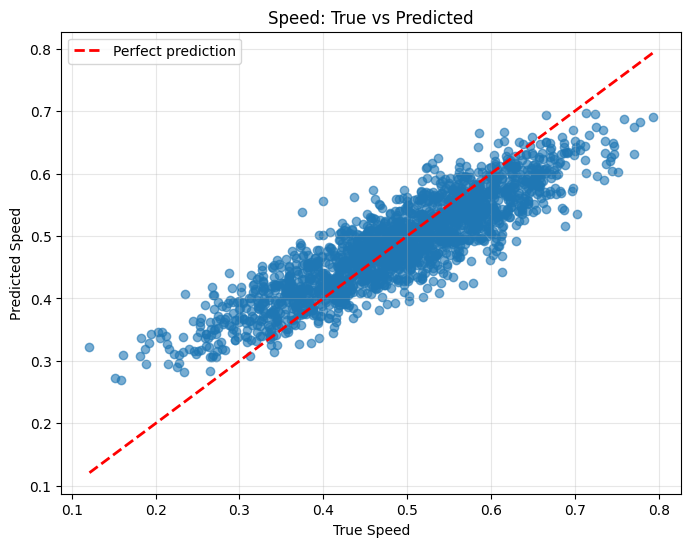

In [14]:
#===========================
# 6. Plot for 'speed' (index 0 in final_targets)
# ===========================
speed_true = y2_test_true_orig[:, 0]
speed_pred = y2_test_pred_orig[:, 0]

min_val = min(speed_true.min(), speed_pred.min())
max_val = max(speed_true.max(), speed_pred.max())

plt.figure(figsize=(8, 6))
plt.scatter(speed_true, speed_pred, alpha=0.6)
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label="Perfect prediction")
plt.xlabel("True Speed")
plt.ylabel("Predicted Speed")
plt.title("Speed: True vs Predicted")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# # Save final models if needed
torch.save(stage1_model.state_dict(), "best_stage1.pth")
torch.save(stage2_model.state_dict(), "best_stage2.pth")